In [1]:
cd /content/drive/MyDrive/Colab Notebooks/MIL-NCE_HowTo100M/npy

/content/drive/MyDrive/Colab Notebooks/MIL-NCE_HowTo100M/npy


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 데이터를 GPU로 이동
video = video_data.to(device)
audio = audio_data.to(device)

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 초기화 및 GPU로 이동
model = proj_head().to(device)
model.train()

# 손실 함수 및 옵티마이저 설정
loss_fn = NCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 및 검증 파라미터 설정
num_epochs = 200
batch_size = 64
validation_batch_size = 4
NCElosses = []
validation_losses = []

# 학습 및 검증 반복
for epoch in range(num_epochs):
    optimizer.zero_grad()  # 그라디언트 초기화

    # 트레이닝 데이터에서 배치 단위로 데이터 가져오기
    num_samples = len(video)
    indices = torch.randperm(num_samples)
    video = video[indices]
    audio = audio[indices]

    for i in range(0, num_samples, batch_size):
        # 배치 데이터 가져오기
        video_batch = video[i:i+batch_size]
        audio_batch = audio[i:i+batch_size]

        # Forward pass
        v_, a_ = model.forward(x=video_batch, y=audio_batch)
        NCEloss = loss_fn(v_, a_)  # 손실 계산

        # Backward pass 및 가중치 업데이트
        NCEloss.backward()
        optimizer.step()

        NCElosses.append(NCEloss.item())

    # 검증 데이터에 대한 손실 계산
    with torch.no_grad():
        # 트레이닝 데이터에서 배치 크기로 데이터 가져오기
        num_validation_batches = num_samples // batch_size

        for i in range(num_validation_batches):
            # 배치 데이터 가져오기
            validation_indices = torch.randperm(num_samples)[:validation_batch_size]
            video_batch = video[validation_indices].to(device)
            audio_batch = audio[validation_indices].to(device)

            # Forward pass
            v_, a_ = model.forward(x=video_batch, y=audio_batch)
            NCEloss = loss_fn(v_, a_)  # 손실 계산

            validation_losses.append(NCEloss.item())

    # 현재 에포크의 학습 및 검증 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {NCElosses[-1]}, Validation Loss: {validation_losses[-1]}")

# 학습 및 검증 손실 그래프 출력
plt.plot(NCElosses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 학습 완료 후 모델 저장
torch.save(model.state_dict(), 'NCEloss.pth')


Proj_head

In [2]:
import torch
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt

In [7]:
video_data = np.load('video_before_head.npy')
video_data = th.from_numpy(video_data)
video_data = video_data.squeeze(1)
audio_data = np.load('audio_before_head.npy')
audio_data = th.from_numpy(audio_data)
audio_data = audio_data.squeeze(1)
text_data = np.load('text_before_head1.npy')
text_data = th.from_numpy(text_data)
text_data = audio_data.squeeze(1)

In [36]:
class CustomtrainDataset(torch.utils.data.Dataset):
  def __init__(self,):
    self.x_data = np.load('video_before_head.npy', allow_pickle=True)
    self.y_data = np.load('audio_before_head.npy', allow_pickle=True)
    self.z_data = np.load('text_before_head1.npy', allow_pickle=True)

  def __len__(self):
      return len(self.x_data)

  def __getitem__(self, idx):
      x = self.x_data[idx]
      y = self.y_data[idx]
      z = self.z_data[idx]
      z = z.squeeze(0)
      x_t = th.from_numpy(x).to(device)
      y_t = th.from_numpy(y).to(device)
      z_t = th.from_numpy(z).to(device)

      return x_t, y_t, z_t

In [37]:
dataset = CustomtrainDataset()

In [38]:
dataset.__getitem__(339)

(tensor([0.0552, 0.0243, 0.0049,  ..., 0.0000, 0.0047, 0.0051], device='cuda:0'),
 tensor([0.0000, 0.9040, 0.0000,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0'),
 tensor([0.1386, 0.2650, 0.0000,  ..., 0.1745, 0.1241, 0.1622], device='cuda:0'))

In [40]:
a, b, c = next(iter(dataset))
c.shape

torch.Size([2048])

In [41]:
# 데이터셋 스플릿
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size =int(dataset_size *0.1)
test_size = dataset_size - train_size - validation_size

generator1 = torch.Generator().manual_seed(42) # random seed 고정
train_dataset, validation_dataset, test_dataset = \
random_split(dataset, [train_size, validation_size, test_size], generator1)

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle = False, drop_last = True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle = False, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle = False, drop_last = True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

Training Data Size : 272
Validation Data Size : 34
Testing Data Size : 34


True

데이터셋 확인

In [44]:
a, b, c = next(iter(train_dataloader))
a.shape

torch.Size([64, 1024])

proj_head

In [65]:
class proj_head(nn.Module):
  def __init__(self):
    super().__init__()
    self.vid = nn.Sequential(
        nn.Linear(1024, 512, bias=True),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 512, bias=True),
        nn.BatchNorm1d(512),
    )
    self.aud = nn.Linear(2048, 512, bias=True)
    self.tex = nn.Sequential(
        nn.Linear(2048, 512, bias=True),
        nn.ReLU()
    )
  def forward(self, x, y, z):
    x1 = self.vid(x)
    y1 = self.aud(y)
    z1 = self.tex(z)
    return x1, y1, z1

NCELoss

In [66]:
class NCELoss(nn.Module):
    def __init__(self ,temperature=0.07):
        super(NCELoss, self).__init__()
        self.temperature = temperature

    def forward(self, v_f, a_f, t_f):
        v_f = F.normalize(v_f, dim=-1)
        a_f = F.normalize(a_f, dim=-1)
        t_f = F.normalize(t_f, dim=-1)
        possim1 = []
        negsim1 = []
        NCE = []
        start_index = 0

        # Pos, neg pair 만들기
        for i in range(v_f.size(0)):
            possim = torch.matmul(v_f[i], a_f[i])
            possim1.append(possim)
            for j in range(v_f.size(0)):
                if i != j:
                    negsim = torch.matmul(v_f[i], a_f[j])
                    negsim1.append(negsim)

        # NCELoss 계산
        for k in range(v_f.size(0)):
            sumexp_all = 0
            sumexp_neg = 0
            end_index = start_index + v_f.size(0)
            exp_pos = torch.exp(possim1[k] / self.temperature)

            for l in range(end_index):
                sumexp_neg += torch.exp(negsim1[l] / self.temperature)
            sumexp_all = exp_pos + sumexp_neg
            loss = torch.log(sumexp_all) - torch.log(exp_pos)
            NCE.append(loss)


        possim_vt1 = []
        negsim_vt1 = []
        NCE_vt = []
        start_index_vt = 0

        # Pos, neg pair 만들기
        for i in range(v_f.size(0)):
            possim_vt = torch.matmul(v_f[i], t_f[i])
            possim_vt1.append(possim_vt)
            for j in range(v_f.size(0)):
                if i != j:
                    negsim_vt = torch.matmul(v_f[i], t_f[j])
                    negsim_vt1.append(negsim_vt)

        # NCELoss 계산
        for k in range(v_f.size(0)):
            sumexp_all_vt = 0
            sumexp_neg_vt = 0
            end_index_vt = start_index_vt + v_f.size(0)
            exp_pos_vt = torch.exp(possim_vt1[k] / self.temperature)

            for l in range(end_index_vt):
                sumexp_neg_vt += torch.exp(negsim_vt1[l] / self.temperature)
            sumexp_all_vt = exp_pos_vt + sumexp_neg_vt
            loss_vt = torch.log(sumexp_all_vt) - torch.log(exp_pos_vt)
            NCE_vt.append(loss_vt)
        # list -> tensor화
        NCE = torch.stack(NCE)
        NCE_vt = torch.stack(NCE_vt)
        # None값 제거
        NCE = torch.where(torch.isnan(NCE), torch.zeros_like(NCE), NCE)
        NCE_vt = torch.where(torch.isnan(NCE_vt), torch.zeros_like(NCE_vt), NCE_vt)

        loss = torch.mean(NCE)
        loss_vt = torch.mean(NCE_vt)
        return loss, loss_vt


Train & Val

Epoch 1/30, Train Loss: 8.693027973175049, Validation Loss: 7.190041542053223
Epoch 2/30, Train Loss: 7.7093483209609985, Validation Loss: 7.129622459411621
Epoch 3/30, Train Loss: 6.83425498008728, Validation Loss: 7.096473693847656
Epoch 4/30, Train Loss: 6.056412696838379, Validation Loss: 7.063610076904297
Epoch 5/30, Train Loss: 5.372936010360718, Validation Loss: 7.024621963500977
Epoch 6/30, Train Loss: 4.7684286236763, Validation Loss: 6.981481075286865
Epoch 7/30, Train Loss: 4.2370946407318115, Validation Loss: 6.929004192352295
Epoch 8/30, Train Loss: 3.776310622692108, Validation Loss: 6.863743782043457
Epoch 9/30, Train Loss: 3.378144860267639, Validation Loss: 6.7830305099487305
Epoch 10/30, Train Loss: 3.0329774022102356, Validation Loss: 6.681540489196777
Epoch 11/30, Train Loss: 2.7338099479675293, Validation Loss: 6.556900978088379
Epoch 12/30, Train Loss: 2.4723354876041412, Validation Loss: 6.408235549926758
Epoch 13/30, Train Loss: 2.2438876926898956, Validation Lo

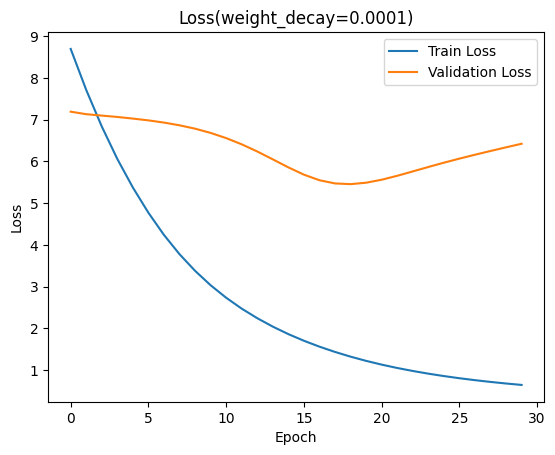

In [72]:
# 모델 초기화 및 GPU로 이동
model = proj_head().to(device)

# 손실 함수 및 옵티마이저 설정
loss_fn = NCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.0001)

# 학습 및 검증 파라미터 설정
num_epochs = 30
NCElosses = []
validation_losses = []

# 학습 및 검증 반복
for epoch in range(num_epochs):
    all_loss = 0
    optimizer.zero_grad()  # 그라디언트 초기화

    # 트레이닝 데이터에서 배치 단위로 데이터 가져오기
    model.train()
    for video, audio, text in train_dataloader:
        # Forward pass
        video = video.to(device)
        audio = audio.to(device)
        text = text.to(device)
        v_, a_, t_ = model.forward(x=video, y=audio, z=text)
        NCEloss1, NCEloss2 = loss_fn(v_, a_, t_)  # 손실 계산
        # print(NCEloss1,NCEloss2)
        NCEloss = NCEloss1 + NCEloss2
        all_loss += NCEloss.item()
        # Backward pass 및 가중치 업데이트
        NCEloss.backward()
        optimizer.step()
        gc.collect()
        torch.cuda.empty_cache()

    with torch.no_grad():
        # 검증 데이터에 대한 손실 계산
        model.eval()
        val_loss = 0
        # 트레이닝 데이터에서 배치 크기로 데이터 가져오기
        for video, audio, text in validation_dataloader:

            v_, a_, t_ = model.forward(x=video, y=audio, z=text)
            NCEloss1, NCEloss2 = loss_fn(v_, a_, t_)  # 손실 계산
            # print(NCEloss1,NCEloss2)
            NCEloss = NCEloss1 + NCEloss2
            val_loss += NCEloss.item()
            gc.collect()
            torch.cuda.empty_cache()

    epoch_loss = all_loss / len(train_dataloader)
    valid_epoch_loss = val_loss / len(validation_dataloader)
    NCElosses.append(epoch_loss)
    validation_losses.append(valid_epoch_loss)

    # 현재 에포크의 학습 및 검증 손실 출력
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss}, Validation Loss: {valid_epoch_loss}")
    gc.collect()
    torch.cuda.empty_cache()

# 학습 및 검증 손실 그래프 출력
plt.plot(NCElosses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss(weight_decay=0.0001)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 학습 완료 후 모델 저장
torch.save(model.state_dict(), 'weight_decay00001.pth')


inference

In [84]:
model = proj_head().to(device)
model.load_state_dict(torch.load('weight_decay00001.pth'))
model.eval()
similarities = []
for video, audio, text in test_dataloader:
  # 모델을 통과한 후의 결과 얻기
  video_feature, audio_feature, text_feature = model(video, audio, text)

  # 코사인 유사도 계산
  similarity1 = torch.cosine_similarity(video_feature, audio_feature)
  similarity2 = torch.cosine_similarity(video_feature, text_feature)
  print(similarity1,similarity2)
  similarity = (similarity1+similarity2)/2
  similarities.append(similarity)
# 비디오-오디오 쌍의 랭킹 계산
_, ranking = similarity.sort(descending=True)

print("비디오-오디오 및 비디오-텍스트 쌍의 랭킹:")
print(ranking)

tensor([-0.0249,  0.0284,  0.1827, -0.2291,  0.1378,  0.0488,  0.0029, -0.0357,
         0.1498, -0.1133,  0.0183,  0.1077,  0.0801, -0.0142, -0.0064, -0.0433,
        -0.1689,  0.0854, -0.0669,  0.1093,  0.0793, -0.0371,  0.0450,  0.1085,
         0.0627,  0.0797, -0.1465,  0.0127,  0.0244,  0.1683, -0.0466,  0.0286],
       device='cuda:0', grad_fn=<SumBackward1>) tensor([-0.0436,  0.0249,  0.1531, -0.1985,  0.0887,  0.0434, -0.0140, -0.0654,
         0.0872, -0.1107,  0.0232,  0.1375,  0.1024, -0.1003,  0.0389, -0.0590,
        -0.1612,  0.0644, -0.0134,  0.1138,  0.1131, -0.0126,  0.0351,  0.0519,
         0.0323,  0.0075, -0.1532, -0.0791,  0.0016,  0.1582, -0.1163, -0.0750],
       device='cuda:0', grad_fn=<SumBackward1>)
비디오-오디오 및 비디오-텍스트 쌍의 랭킹:
tensor([ 2, 29, 11,  8,  4, 19, 20, 12, 23, 17, 24,  5, 25, 22,  1, 10, 14, 28,
         6, 31, 21, 27,  0, 18,  7, 15, 13, 30,  9, 26, 16,  3],
       device='cuda:0')


In [80]:
similarity[29]

tensor(0.1632, device='cuda:0', grad_fn=<SelectBackward0>)